In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy
from datetime import datetime
import datetime as dt
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
%matplotlib inline

In [3]:
nba_stats = pd.read_csv('https://raw.githubusercontent.com/trillmonger/datasci_thinkful/refs/heads/main/csv/nba_game_data.csv', index_col=0)

In [5]:
nba_stats.head(10)

,mp,mp.1,fg,fga,fg%,3p,3pa,3p%,ft,fta,...,tov%_max_opp,usg%_max_opp,ortg_max_opp,drtg_max_opp,team_opp,total_opp,home_opp,season,date,won
0,240.0,240.0,37.0,85.0,0.435,8.0,19.0,0.421,17.0,23.0,...,20.0,30.9,148.0,116.0,SAS,107,1,2018,2017-10-18,False
1,240.0,240.0,41.0,89.0,0.461,8.0,21.0,0.381,17.0,19.0,...,28.6,30.9,138.0,118.0,MIN,99,0,2018,2017-10-18,True
2,240.0,240.0,27.0,86.0,0.314,6.0,26.0,0.231,15.0,20.0,...,16.8,30.9,157.0,90.0,MEM,92,1,2021,2021-04-30,False
3,240.0,240.0,34.0,99.0,0.343,11.0,39.0,0.282,13.0,16.0,...,33.9,27.2,106.0,106.0,ORL,75,0,2021,2021-04-30,True
4,240.0,240.0,35.0,83.0,0.422,9.0,24.0,0.375,12.0,18.0,...,33.3,30.9,171.0,105.0,MIN,107,1,2017,2017-03-08,False
5,240.0,240.0,42.0,86.0,0.488,5.0,20.0,0.250,18.0,20.0,...,32.0,32.4,158.0,126.0,LAC,91,0,2017,2017-03-08,True
6,240.0,240.0,44.0,87.0,0.506,10.0,23.0,0.435,27.0,32.0,...,22.5,38.2,179.0,140.0,DAL,121,1,2019,2019-03-26,True
7,240.0,240.0,39.0,77.0,0.506,15.0,45.0,0.333,28.0,32.0,...,23.7,31.4,188.0,136.0,SAC,125,0,2019,2019-03-26,False
8,265.0,265.0,46.0,100.0,0.460,15.0,39.0,0.385,25.0,32.0,...,20.7,39.9,160.0,125.0,NOP,138,1,2020,2020-01-16,False
9,265.0,265.0,51.0,93.0,0.548,11.0,26.0,0.423,25.0,35.0,...,25.0,39.5,197.0,132.0,UTA,132,0,2020,2020-01-16,True


In [7]:
#need to sort the values by date then reset the index. 

nba_stats = nba_stats.sort_values('date')

In [9]:
#resetting the index so that it matches the dates
nba_stats = nba_stats.reset_index(drop=True)

In [11]:
#EDA  removing of columns mp1, mp_opp1 and index_opp because they are not relevant for our dataset 

del nba_stats['mp.1'] # identical to mp column 
del nba_stats['mp_opp.1'] # same as 
del nba_stats['index_opp'] # this was added for opponent indexing so not needed  


In [13]:
#Creating a target function to create a column for my prediction values 

def add_target(group):
    group['target'] = group['won'].shift(-1)
    group = group.copy()
    return group

nba_stats = nba_stats.groupby('team', group_keys=False).apply(add_target) #splitting dataframe by team so we can see how the stats of each team grouped 

/var/folders/dt/_vx_4f6x7rx7_zdn2gc3sn1r0000gp/T/ipykernel_872/3746645359.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  group['target'] = group['won'].shift(-1)
/var/folders/dt/_vx_4f6x7rx7_zdn2gc3sn1r0000gp/T/ipykernel_872/3746645359.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  group['target'] = group['won'].shift(-1)
/var/folders/dt/_vx_4f6x7rx7_zdn2gc3sn1r0000gp/T/ipykernel_872/3746645359.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, wh

In [15]:
nba_stats[nba_stats['team'] == 'MEM']


,mp,fg,fga,fg%,3p,3pa,3p%,ft,fta,ft%,...,usg%_max_opp,ortg_max_opp,drtg_max_opp,team_opp,total_opp,home_opp,season,date,won,target
19,240.0,36.0,80.0,0.450,11.0,24.0,0.458,19.0,27.0,0.704,...,28.4,137.0,119.0,MIN,98,0,2017,2016-10-26,True,False
52,240.0,37.0,86.0,0.430,9.0,25.0,0.360,21.0,26.0,0.808,...,34.2,149.0,113.0,NYK,111,1,2017,2016-10-29,False,True
74,265.0,39.0,88.0,0.443,15.0,31.0,0.484,19.0,26.0,0.731,...,34.0,205.0,122.0,WAS,103,0,2017,2016-10-30,True,False
93,240.0,27.0,75.0,0.360,4.0,24.0,0.167,22.0,29.0,0.759,...,48.9,139.0,89.0,MIN,116,1,2017,2016-11-01,False,True
116,265.0,33.0,94.0,0.351,8.0,27.0,0.296,15.0,20.0,0.750,...,28.2,124.0,100.0,NOP,83,0,2017,2016-11-02,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13159,240.0,36.0,91.0,0.396,14.0,45.0,0.311,20.0,21.0,0.952,...,31.1,123.0,116.0,GSW,101,0,2022,2022-05-03,True,False
13172,240.0,40.0,92.0,0.435,16.0,43.0,0.372,16.0,21.0,0.762,...,34.7,214.0,116.0,GSW,142,1,2022,2022-05-07,False,False
13180,240.0,40.0,96.0,0.417,9.0,35.0,0.257,9.0,15.0,0.600,...,35.2,225.0,100.0,GSW,101,1,2022,2022-05-09,False,True
13187,240.0,47.0,99.0,0.475,18.0,41.0,0.439,22.0,30.0,0.733,...,35.0,128.0,140.0,GSW,95,0,2022,2022-05-11,True,False


In [17]:
# Now that the dataFrame is organized, reducing the amount of variables from 152 to 10. 
nba_stats.info() 

<class 'pandas.core.frame.DataFrame'>
Index: 13226 entries, 0 to 13225
Columns: 152 entries, mp to target
dtypes: bool(1), float64(142), int64(5), object(4)
memory usage: 15.9+ MB


In [19]:
#EDA to reduce the amount of variables 
nba_stats.head()

,mp,fg,fga,fg%,3p,3pa,3p%,ft,fta,ft%,...,usg%_max_opp,ortg_max_opp,drtg_max_opp,team_opp,total_opp,home_opp,season,date,won,target
0,240.0,47.0,98.0,0.480,12.0,24.0,0.500,23.0,26.0,0.885,...,31.8,139.0,143.0,GSW,100,1,2017,2016-10-25,True,True
1,240.0,45.0,94.0,0.479,13.0,35.0,0.371,14.0,19.0,0.737,...,36.8,153.0,125.0,NYK,88,0,2017,2016-10-25,True,True
2,240.0,40.0,82.0,0.488,8.0,24.0,0.333,16.0,16.0,1.000,...,39.2,220.0,120.0,POR,113,1,2017,2016-10-25,False,True
3,240.0,39.0,75.0,0.520,13.0,19.0,0.684,22.0,22.0,1.000,...,29.7,150.0,133.0,UTA,104,0,2017,2016-10-25,True,False
4,240.0,32.0,87.0,0.368,9.0,27.0,0.333,15.0,20.0,0.750,...,36.8,200.0,101.0,CLE,117,1,2017,2016-10-25,False,True


In [21]:
#Building a correlation matrix 

encoder = LabelEncoder()

nba_corr = nba_stats.copy()

for column in nba_corr.select_dtypes(include=['object']).columns:
    nba_corr[column] = encoder.fit_transform(nba_corr[column])


In [23]:
nba_corr.isnull().sum()

mp          0
fg          0
fga         0
fg%         0
3p          0
           ..
home_opp    0
season      0
date        0
won         0
target      0
Length: 152, dtype: int64

In [25]:
#Correlation Matrix

corr_df = nba_corr.corr()

In [27]:
#Ranking the best scoring variables to won column

corr_df['target'].abs().sort_values(ascending = False).head(20)

target          1.000000
+/-_max         0.068962
gmsc_max        0.064865
won             0.060396
+/-_max_opp     0.059741
pts_max         0.054126
drtg_opp        0.050556
ortg            0.050556
drtg_max_opp    0.048296
total_opp       0.046916
pts_opp         0.046916
ast_max         0.045107
fg_opp          0.045104
fg_max          0.044811
ts%             0.043469
ortg_opp        0.043310
drtg            0.043310
fg%_opp         0.041719
ft_max          0.041441
blk%            0.041423
Name: target, dtype: float64

In [29]:
#Selected the best features from the correlation..
time_series_feats = ['date','+/-_max','gmsc_max','+/-_max_opp','pts_max','drtg_opp','ortg','drtg_max_opp','total_opp','pts_opp','won', 'target','season','team']
selected_feats = ['date','+/-_max','gmsc_max','+/-_max_opp','pts_max','drtg_opp','ortg','drtg_max_opp','total_opp','pts_opp','won', 'target','season']

array([[<Axes: title={'center': '+/-_max'}>,
        <Axes: title={'center': 'gmsc_max'}>,
        <Axes: title={'center': '+/-_max_opp'}>],
       [<Axes: title={'center': 'pts_max'}>,
        <Axes: title={'center': 'drtg_opp'}>,
        <Axes: title={'center': 'ortg'}>],
       [<Axes: title={'center': 'drtg_max_opp'}>,
        <Axes: title={'center': 'total_opp'}>,
        <Axes: title={'center': 'pts_opp'}>],
       [<Axes: title={'center': 'season'}>, <Axes: >, <Axes: >]],
      dtype=object)

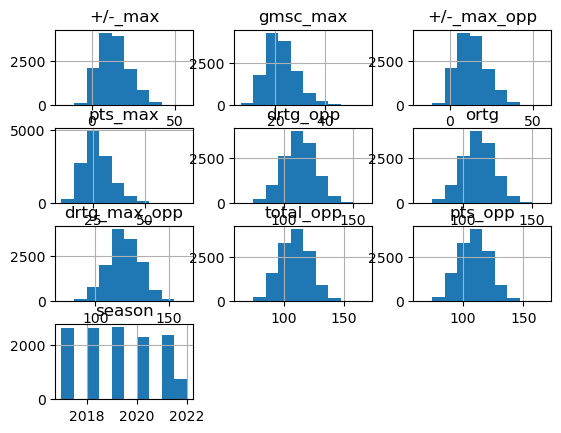

In [31]:
#Distribution of selected features
nba_stats[selected_feats].hist()

In [33]:
nba_stats['date']

0        2016-10-25
1        2016-10-25
2        2016-10-25
3        2016-10-25
4        2016-10-25
            ...    
13221    2022-05-26
13222    2022-05-27
13223    2022-05-27
13224    2022-05-29
13225    2022-05-29
Name: date, Length: 13226, dtype: object

/opt/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


<Axes: >

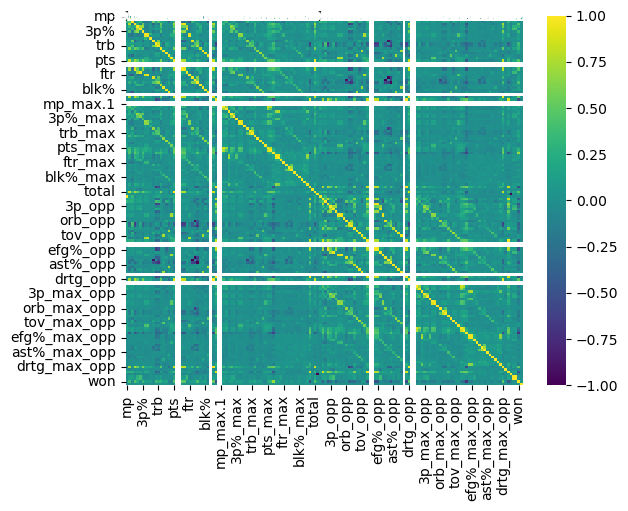

In [35]:
#Creating a heatmap for the correlation between features for selection
sns.heatmap(corr_df, cmap='viridis',annot=True)



In [37]:
nba_stats_select = nba_stats[selected_feats]

In [39]:
nba_stats_select.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13226 entries, 0 to 13225
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          13226 non-null  object 
 1   +/-_max       13226 non-null  float64
 2   gmsc_max      13226 non-null  float64
 3   +/-_max_opp   13226 non-null  float64
 4   pts_max       13226 non-null  float64
 5   drtg_opp      13226 non-null  float64
 6   ortg          13226 non-null  float64
 7   drtg_max_opp  13226 non-null  float64
 8   total_opp     13226 non-null  int64  
 9   pts_opp       13226 non-null  float64
 10  won           13226 non-null  bool   
 11  target        13196 non-null  object 
 12  season        13226 non-null  int64  
dtypes: bool(1), float64(8), int64(2), object(2)
memory usage: 1.8+ MB


In [41]:
#Looking for null values in the target variable and replacing them with value 2 
nba_stats_select["target"][pd.isnull(nba_stats_select["target"])] = 2


/var/folders/dt/_vx_4f6x7rx7_zdn2gc3sn1r0000gp/T/ipykernel_872/1762410583.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nba_stats_select["target"][pd.isnull(nba_stats_select["target"])] = 2


In [43]:
#transforming boolean values to integer 
nba_stats_select["target"] = nba_stats_select["target"].astype(int, errors="ignore")
nba_stats_select['won'] = nba_stats_select['won'].astype(int, errors="ignore")
nba_stats_select["date"] = nba_stats_select['date'].astype(int, errors="ignore")

/var/folders/dt/_vx_4f6x7rx7_zdn2gc3sn1r0000gp/T/ipykernel_872/2279615237.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nba_stats_select["target"] = nba_stats_select["target"].astype(int, errors="ignore")
/var/folders/dt/_vx_4f6x7rx7_zdn2gc3sn1r0000gp/T/ipykernel_872/2279615237.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nba_stats_select['won'] = nba_stats_select['won'].astype(int, errors="ignore")
/var/folders/dt/_vx_4f6x7rx7_zdn2gc3sn1r0000gp/T/ipykernel_872/2279615237.py:4: SettingWithCopyW

In [45]:
nba_stats_select["target"].value_counts()

target
0    6599
1    6597
2      30
Name: count, dtype: int64

In [47]:
nba_stats_select["won"].value_counts()

won
1    6613
0    6613
Name: count, dtype: int64

In [49]:
#Checking null values 

nba_stats_select.isnull().sum()

date            0
+/-_max         0
gmsc_max        0
+/-_max_opp     0
pts_max         0
drtg_opp        0
ortg            0
drtg_max_opp    0
total_opp       0
pts_opp         0
won             0
target          0
season          0
dtype: int64

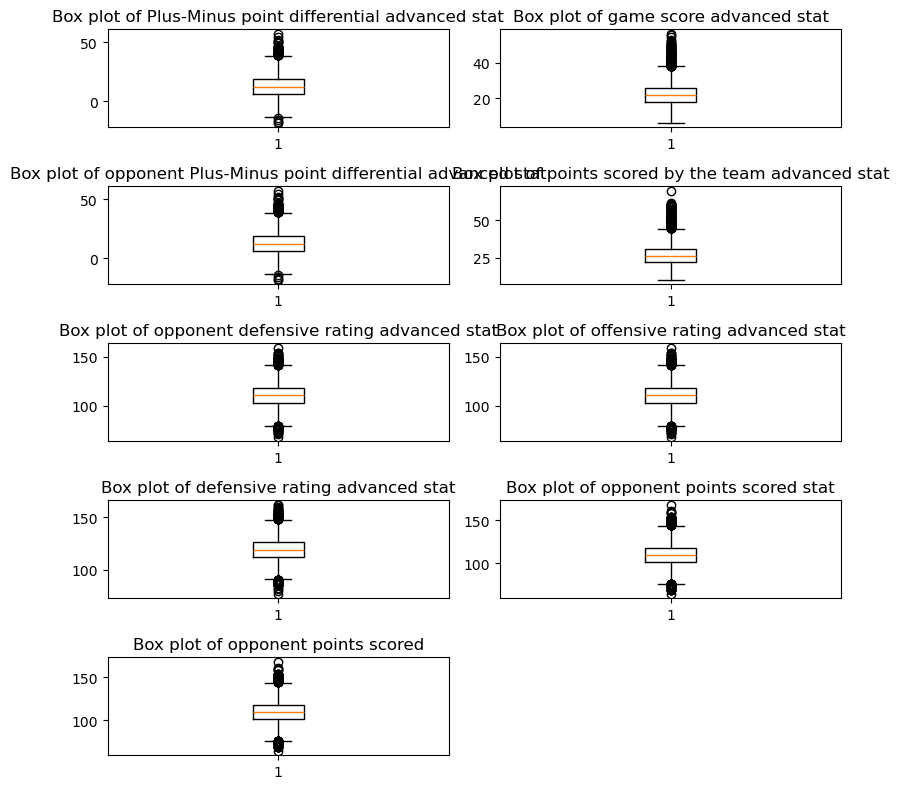

In [51]:
#checking for outliers 
plt.figure(figsize=(8,8))

plt.subplot(5, 2, 1)
plt.boxplot(nba_stats_select["+/-_max"])
plt.title("Box plot of Plus-Minus point differential advanced stat")

plt.subplot(5, 2, 2)
plt.boxplot(nba_stats_select["gmsc_max"])
plt.title("Box plot of game score advanced stat")

plt.subplot(5, 2, 3)
plt.boxplot(nba_stats_select["+/-_max_opp"])
plt.title("Box plot of opponent Plus-Minus point differential advanced stat")

plt.subplot(5, 2, 4)
plt.boxplot(nba_stats_select["pts_max"])
plt.title("Box plot of points scored by the team advanced stat")

plt.subplot(5, 2, 5)
plt.boxplot(nba_stats_select["drtg_opp"])
plt.title("Box plot of opponent defensive rating advanced stat")

plt.subplot(5, 2, 6)
plt.boxplot(nba_stats_select["ortg"])
plt.title("Box plot of offensive rating advanced stat")

plt.subplot(5, 2, 7)
plt.boxplot(nba_stats_select["drtg_max_opp"])
plt.title("Box plot of defensive rating advanced stat")

plt.subplot(5, 2, 8)
plt.boxplot(nba_stats_select["total_opp"])
plt.title("Box plot of opponent points scored stat")

plt.subplot(5, 2, 9)
plt.boxplot(nba_stats_select["pts_opp"])
plt.title("Box plot of opponent points scored")

plt.tight_layout()
plt.show()

In [53]:
#winsorize function
def winsorize_column(column, limits):
    return winsorize(column, limits)

# Create a copy of the original DataFrame
winsor_stats = nba_stats_select.copy()

# Apply the winsorize function to the specified columns in the new DataFrame
for feat in selected_feats:
    winsor_stats[feat] = winsorize_column(winsor_stats[feat], (0, 0.10))

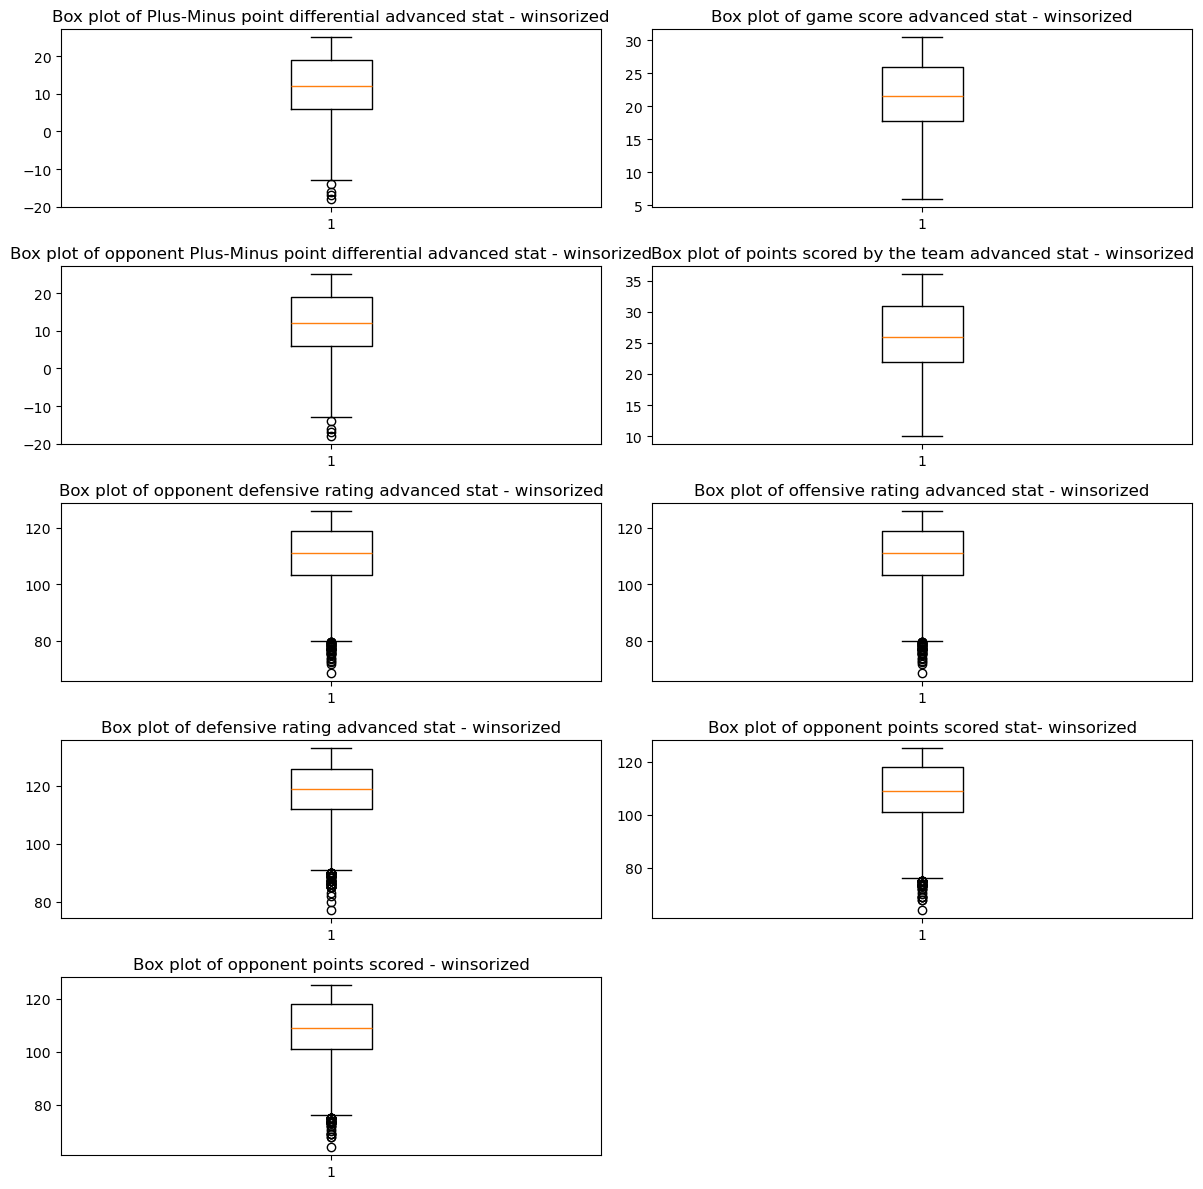

In [55]:
#graph winsorized data 

plt.figure(figsize=(12, 12))

plt.subplot(5, 2, 1)
plt.boxplot(winsor_stats["+/-_max"])
plt.title("Box plot of Plus-Minus point differential advanced stat - winsorized")

plt.subplot(5, 2, 2)
plt.boxplot(winsor_stats["gmsc_max"])
plt.title("Box plot of game score advanced stat - winsorized")

plt.subplot(5, 2, 3)
plt.boxplot(winsor_stats["+/-_max_opp"])
plt.title("Box plot of opponent Plus-Minus point differential advanced stat - winsorized")

plt.subplot(5, 2, 4)
plt.boxplot(winsor_stats["pts_max"])
plt.title("Box plot of points scored by the team advanced stat - winsorized")

plt.subplot(5, 2, 5)
plt.boxplot(winsor_stats["drtg_opp"])
plt.title("Box plot of opponent defensive rating advanced stat - winsorized")

plt.subplot(5, 2, 6)
plt.boxplot(winsor_stats["ortg"])
plt.title("Box plot of offensive rating advanced stat - winsorized")

plt.subplot(5, 2, 7)
plt.boxplot(winsor_stats["drtg_max_opp"])
plt.title("Box plot of defensive rating advanced stat - winsorized")

plt.subplot(5, 2, 8)
plt.boxplot(winsor_stats["total_opp"])
plt.title("Box plot of opponent points scored stat- winsorized")

plt.subplot(5, 2, 9)
plt.boxplot(winsor_stats["pts_opp"])
plt.title("Box plot of opponent points scored - winsorized")

plt.tight_layout()
plt.show()

In [57]:
#creating df for modeling 
ml_stats = nba_stats_select[selected_feats]
ml_winsor = winsor_stats[selected_feats]

ml_stats.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13226 entries, 0 to 13225
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          13226 non-null  object 
 1   +/-_max       13226 non-null  float64
 2   gmsc_max      13226 non-null  float64
 3   +/-_max_opp   13226 non-null  float64
 4   pts_max       13226 non-null  float64
 5   drtg_opp      13226 non-null  float64
 6   ortg          13226 non-null  float64
 7   drtg_max_opp  13226 non-null  float64
 8   total_opp     13226 non-null  int64  
 9   pts_opp       13226 non-null  float64
 10  won           13226 non-null  int64  
 11  target        13226 non-null  int64  
 12  season        13226 non-null  int64  
dtypes: float64(8), int64(4), object(1)
memory usage: 1.9+ MB


In [59]:
null_columns = ml_stats.columns[ml_stats.isnull().any()] 
print(null_columns)

Index([], dtype='object')


In [61]:
winsor_columns = ml_winsor.columns[ml_winsor.isnull().any()] 
print(null_columns)

Index([], dtype='object')


In [63]:
# dropping the rows with the 2 value in target

ml_stats = ml_stats[ml_stats['target'] != 2]
ml_winsor = ml_stats[ml_stats['target'] != 2]

In [65]:
ml_stats["target"].value_counts()

target
0    6599
1    6597
Name: count, dtype: int64

In [67]:
from sklearn.linear_model import RidgeClassifier
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import TimeSeriesSplit

rr = RidgeClassifier(alpha=1)

split = TimeSeriesSplit(n_splits=3)

sfs = SequentialFeatureSelector(rr, 
                                n_features_to_select=10, 
                                direction="forward",
                                cv=split,
                                n_jobs=1
                               )

In [69]:
#scale original and winsorized data 
from sklearn.preprocessing import MinMaxScaler

#dont want to scale the season variable for time series analysis 
no_scale_cols = ['season', 'date','team']
scale_cols = ml_stats.columns[~ml_stats.columns.isin(no_scale_cols)]


scaler = MinMaxScaler()
ml_stats[scale_cols] = scaler.fit_transform(ml_stats[scale_cols])
ml_winsor[scale_cols] = scaler.fit_transform(ml_winsor[scale_cols])

In [71]:
ml_stats.info()
ml_winsor.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13196 entries, 0 to 13223
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          13196 non-null  object 
 1   +/-_max       13196 non-null  float64
 2   gmsc_max      13196 non-null  float64
 3   +/-_max_opp   13196 non-null  float64
 4   pts_max       13196 non-null  float64
 5   drtg_opp      13196 non-null  float64
 6   ortg          13196 non-null  float64
 7   drtg_max_opp  13196 non-null  float64
 8   total_opp     13196 non-null  float64
 9   pts_opp       13196 non-null  float64
 10  won           13196 non-null  float64
 11  target        13196 non-null  float64
 12  season        13196 non-null  int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 1.4+ MB
<class 'pandas.core.frame.DataFrame'>
Index: 13196 entries, 0 to 13223
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  ----- 

In [73]:
model_train = ml_stats[['+/-_max','gmsc_max','+/-_max_opp','pts_max','drtg_opp','ortg','drtg_max_opp','total_opp','pts_opp','won']]
model_target = ml_stats['target']

winsor_model_train = ml_winsor[['+/-_max','gmsc_max','+/-_max_opp','pts_max','drtg_opp','ortg','drtg_max_opp','total_opp','pts_opp','won']]
winsor_model_target = ml_winsor['target']
#train and Test data
X_train, X_test, y_train, y_test = train_test_split(model_train, model_target, test_size=.2, random_state=40)
winsor_X_train, winsor_X_test, winsor_y_train, winsor_y_test = train_test_split(winsor_model_train, winsor_model_target, test_size=.2, random_state=40)

In [75]:
#Classification Models

#Random Forest
rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=40, oob_score=True)
rf = rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

print(f'RF Classification Report: {classification_report(y_test, rf_pred)}')


#mse = mean_squared_error(y_test,rf_pred)
#r2 = r2_score(y_test,rf_pred)
#print(f"Random Forest Mean Squared Error: {mse}")
#print(f"Random Forest R-Squared: {r2}")

#Winsorized - Random Forest
rf_winsor = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=40)
rf_winsor = rf_winsor.fit(winsor_X_train, winsor_y_train)
winsor_predict = rf_winsor.predict(winsor_X_test)

print(f'Winsorized {classification_report(winsor_y_test, winsor_predict)}')

#winsor_mse = mean_squared_error(winsor_y_test, winsor_predict)
#winsor_r2 = r2_score(winsor_y_test, winsor_predict)
#print(f'Winsorized Mean Squared Error:{winsor_mse}')
#print(f'Winsorized R-Squared:{winsor_mse}')





RF Classification Report:               precision    recall  f1-score   support

         0.0       0.53      0.55      0.54      1329
         1.0       0.53      0.51      0.52      1311

    accuracy                           0.53      2640
   macro avg       0.53      0.53      0.53      2640
weighted avg       0.53      0.53      0.53      2640

Winsorized               precision    recall  f1-score   support

         0.0       0.53      0.55      0.54      1329
         1.0       0.53      0.51      0.52      1311

    accuracy                           0.53      2640
   macro avg       0.53      0.53      0.53      2640
weighted avg       0.53      0.53      0.53      2640



In [77]:
#SVM
svm = SVC(kernel = 'rbf',  C=1.0, gamma='scale', probability=True)

svm.fit(X_train,y_train)

svm_pred = svm.predict(X_test)
print(f'SVM: {classification_report(y_test, svm_pred)}')

svm_winsor = svm.fit(winsor_X_train, winsor_y_train)
svm_winsor_pred = svm.predict(winsor_X_test)
print(f"Winsorized SVM: {classification_report(winsor_y_test, svm_winsor_pred)}")


SVM:               precision    recall  f1-score   support

         0.0       0.53      0.52      0.52      1329
         1.0       0.52      0.53      0.53      1311

    accuracy                           0.53      2640
   macro avg       0.53      0.53      0.53      2640
weighted avg       0.53      0.53      0.53      2640

Winsorized SVM:               precision    recall  f1-score   support

         0.0       0.53      0.52      0.52      1329
         1.0       0.52      0.53      0.53      1311

    accuracy                           0.53      2640
   macro avg       0.53      0.53      0.53      2640
weighted avg       0.53      0.53      0.53      2640



In [79]:
#Ridge Regression
rr = rr.fit(X_train, y_train)
rr_pred = rr.predict(X_test)
print(f"RR: {classification_report(y_test, rr_pred)}")


rr_winsor = rr.fit(winsor_X_train, winsor_y_train)
rr_winsor_pred = rr.predict(winsor_X_test)
print(f'Winsorized Ridge: {classification_report(winsor_y_test, rr_winsor_pred)}')

RR:               precision    recall  f1-score   support

         0.0       0.53      0.53      0.53      1329
         1.0       0.52      0.52      0.52      1311

    accuracy                           0.53      2640
   macro avg       0.53      0.53      0.53      2640
weighted avg       0.53      0.53      0.53      2640

Winsorized Ridge:               precision    recall  f1-score   support

         0.0       0.53      0.53      0.53      1329
         1.0       0.52      0.52      0.52      1311

    accuracy                           0.53      2640
   macro avg       0.53      0.53      0.53      2640
weighted avg       0.53      0.53      0.53      2640



In [ ]:
#Dimension Reduction

#PCA



/var/folders/dt/_vx_4f6x7rx7_zdn2gc3sn1r0000gp/T/ipykernel_872/133340910.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nba_stats_tseries.date = pd.to_datetime(nba_stats_tseries.date)


Text(0, 0.5, 'Maximum +/-')

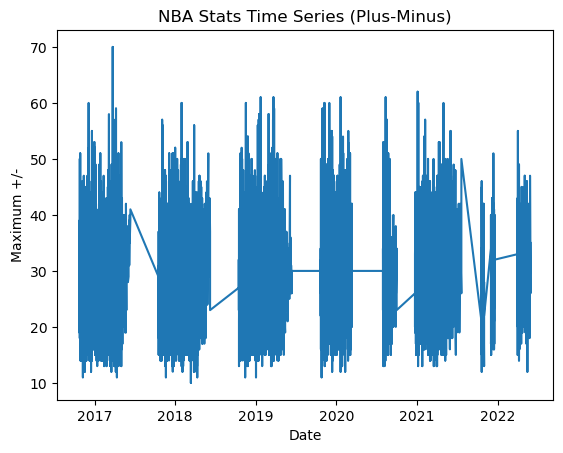

In [81]:
#Time Series Models
#creating new df for time series analysis 
nba_stats_tseries = nba_stats[time_series_feats]
nba_stats_tseries.date = pd.to_datetime(nba_stats_tseries.date)

#Creating Line Graph for visualization 
plt.plot(nba_stats_tseries['date'], nba_stats_tseries['pts_max'])
plt.title('NBA Stats Time Series (Plus-Minus)')
plt.xlabel('Date')
plt.ylabel('Maximum +/-')

In [83]:
#function to separate dataframes by team.
def team_split (df, team_col):
    nba_team = df[team_col].unique()
    
    teams_dfs = {}


    for team in nba_team:
        teams_dfs[team] = df[df[team_col] == team]

    return teams_dfs


In [85]:
frame_of_teams = team_split(nba_stats_tseries, 'team')
nba_stats_tseries.head(20)

,date,+/-_max,gmsc_max,+/-_max_opp,pts_max,drtg_opp,ortg,drtg_max_opp,total_opp,pts_opp,won,target,season,team
0,2016-10-25,35.0,31.7,-3.0,35.0,131.3,131.3,143.0,100,100.0,True,True,2017,SAS
1,2016-10-25,26.0,23.8,-1.0,29.0,117.1,117.1,125.0,88,88.0,True,True,2017,CLE
2,2016-10-25,7.0,24.9,21.0,29.0,114.9,114.9,120.0,113,113.0,False,True,2017,UTA
3,2016-10-25,21.0,32.3,7.0,39.0,124.8,124.8,133.0,104,104.0,True,False,2017,POR
4,2016-10-25,-1.0,9.8,26.0,19.0,88.1,88.1,101.0,117,117.0,False,True,2017,NYK
5,2016-10-25,-3.0,26.8,35.0,27.0,101.8,101.8,112.0,129,129.0,False,True,2017,GSW
6,2016-10-26,14.0,17.2,15.0,21.0,113.6,113.6,118.0,122,122.0,False,True,2017,BRK
7,2016-10-26,13.0,28.4,8.0,32.0,102.6,102.6,110.0,97,97.0,True,True,2017,OKC
8,2016-10-26,8.0,13.4,13.0,20.0,96.7,96.7,102.0,103,103.0,False,False,2017,PHI
9,2016-10-26,10.0,11.4,26.0,18.0,97.1,97.1,105.0,113,113.0,False,False,2017,PHO


In [127]:
mem_df = frame_of_teams['MEM']
mem_df = mem_df.reset_index(drop=True)
mem_df['diff_1'] = mem_df['+/-_max'] - mem_df['+/-_max'].shift()

mem_df.head(20)


,date,+/-_max,gmsc_max,+/-_max_opp,pts_max,drtg_opp,ortg,drtg_max_opp,total_opp,pts_opp,won,target,season,team,diff_1
0,2016-10-26,10.0,16.8,5.0,24.0,111.8,111.8,119.0,98,98.0,True,False,2017,MEM,NaN
1,2016-10-29,10.0,14.7,16.0,20.0,107.9,107.9,113.0,111,111.0,False,True,2017,MEM,0.0
2,2016-10-30,22.0,17.6,3.0,24.0,112.2,112.2,122.0,103,103.0,True,False,2017,MEM,12.0
3,2016-11-01,2.0,15.2,39.0,17.0,82.0,82.0,89.0,116,116.0,False,True,2017,MEM,-20.0
4,2016-11-02,25.0,18.6,17.0,21.0,87.0,87.0,100.0,83,83.0,True,False,2017,MEM,23.0
5,2016-11-04,7.0,28.0,15.0,30.0,92.0,92.0,105.0,99,99.0,False,False,2017,MEM,-18.0
6,2016-11-06,7.0,17.4,17.0,21.0,102.5,102.5,108.0,100,100.0,False,True,2017,MEM,0.0
7,2016-11-08,13.0,18.3,5.0,20.0,109.7,109.7,116.0,107,107.0,True,False,2017,MEM,6.0
8,2016-11-12,4.0,14.0,14.0,18.0,104.0,104.0,111.0,106,106.0,False,True,2017,MEM,-9.0
9,2016-11-14,9.0,17.8,10.0,22.0,120.5,120.5,128.0,96,96.0,True,True,2017,MEM,5.0


Text(0, 0.5, 'Maximum +/-')

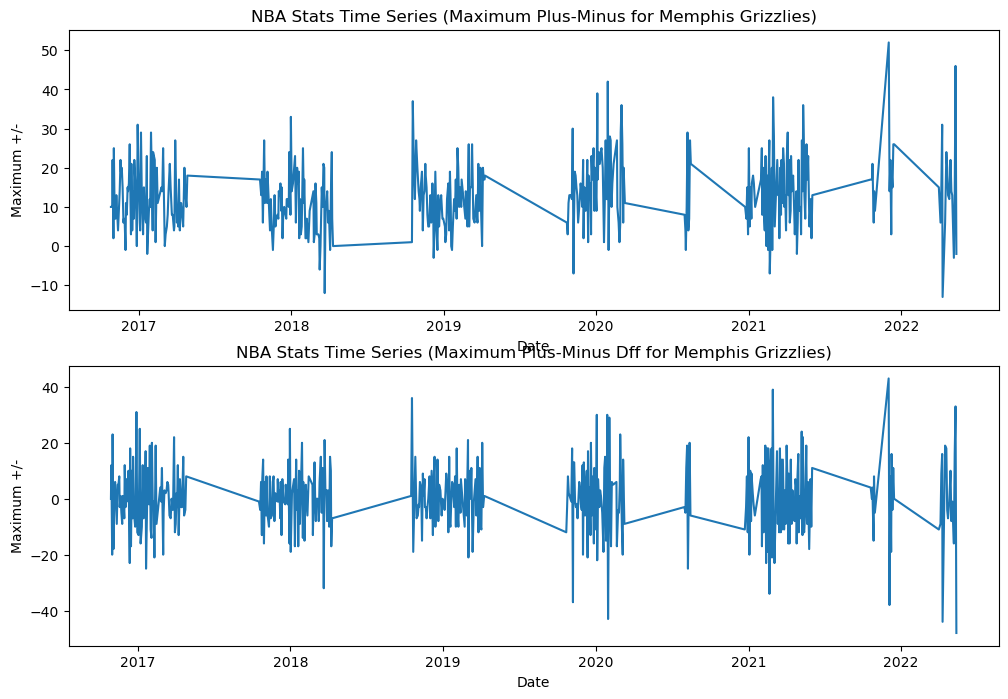

In [99]:
#quick visual example of the Memphis Grizzlies
plt.figure(figsize = (12,8))

plt.subplot(2,1,1)
plt.plot(mem_df['date'], mem_df['+/-_max'])
plt.title('NBA Stats Time Series (Maximum Plus-Minus for Memphis Grizzlies)')
plt.xlabel('Date')
plt.ylabel('Maximum +/-')


#Checking to see if the dataset is stationary
#quick visual example of the Memphis Grizzlies
plt.subplot(2,1,2)
plt.plot(mem_df['date'], mem_df['diff_1'])
plt.title('NBA Stats Time Series (Maximum Plus-Minus Dff for Memphis Grizzlies)')
plt.xlabel('Date')
plt.ylabel('Maximum +/-')


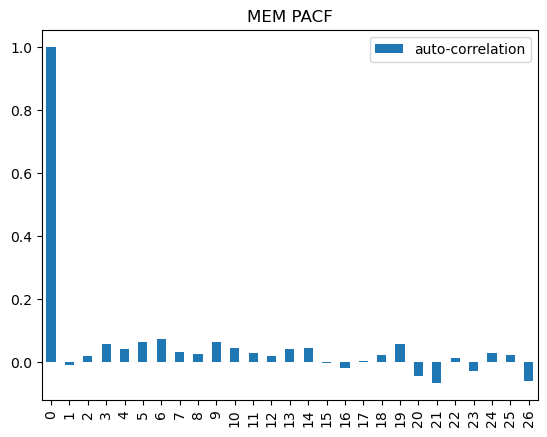

In [91]:
#Looking for Autocorrelations for the time series data
from statsmodels.tsa.stattools import acf, pacf
x_acf = pd.DataFrame(pacf(mem_df['+/-_max']))
x_acf.plot(kind='bar')
plt.title("MEM PACF")
plt.legend(['auto-correlation'])

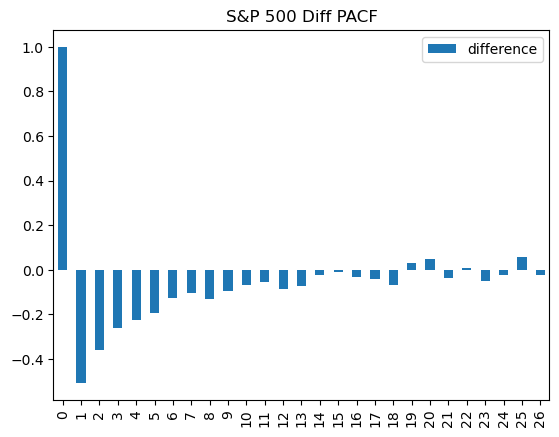

In [93]:
diff_acf = pd.DataFrame(pacf(mem_df['diff_1'][1:]))
diff_acf.plot(kind='bar')
plt.title("S&P 500 Diff PACF")
plt.legend(['difference'])

In [95]:
#ARIMA for Memphis data 
from statsmodels.tsa.arima.model import ARIMA

arima_mem = ARIMA(mem_df['+/-_max'], order = (0,0,1))
arima_mem_fit = arima_mem.fit()
print(arima_mem_fit.summary())
print(arima_mem_fit.resid.describe())

                               SARIMAX Results                                
Dep. Variable:                +/-_max   No. Observations:                  435
Model:                 ARIMA(0, 0, 1)   Log Likelihood               -1568.532
Date:                Wed, 02 Oct 2024   AIC                           3143.064
Time:                        15:34:48   BIC                           3155.290
Sample:                             0   HQIC                          3147.889
                                - 435                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.7382      0.450     28.302      0.000      11.856      13.620
ma.L1         -0.0083      0.046     -0.182      0.856      -0.098       0.082
sigma2        79.3416      4.768     16.639      0.0

In [140]:
mem_df.head()

mem_df.set_index(mem_df.columns[0], inplace=True)
#mem_df.index.dtype

In [162]:
mem_series = mem_df.drop(['team','season','gmsc_max','+/-_max_opp','pts_max','drtg_opp','ortg','drtg_max_opp','total_opp','pts_opp','won','+/-_max','diff_1'],axis = 1)
mem_series = mem_series.dropna()
mem_series = mem_series.astype(int)
mem_series.head()

,target
date,
2016-10-26,0
2016-10-29,1
2016-10-30,0
2016-11-01,1
2016-11-02,0


In [1]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm
from pmdarima import auto_arima

#Sample data - replace this with your actual time series data
# Here we are generating some random data for example purposes

#data = np.random.randn(100).cumsum()  # Cumulative sum to mimic a trend in the data
#index = pd.date_range('2020-01-01', periods=100, freq='D')
time_series = mem_series

# Step 1: Use auto_arima to find the best p, d, q parameters
auto_model = auto_arima(time_series,
                        start_p=1, start_q=1,
                        max_p=5, max_q=5,
                        seasonal=False,  # Assume non-seasonal data here, adjust as needed
                        trace=True,      # Set to True to see the process in console
                        error_action='ignore',  
                        suppress_warnings=True,
                        stepwise=True)   # Use stepwise approach for faster computation

# Display the summary of the auto_arima model
print(auto_model.summary())

# Step 2: Fit the SARIMAX model with the parameters obtained from auto_arima
p, d, q = auto_model.order  # Extract the best p, d, q from auto_arima

# Now fit a SARIMAX model using these parameters
sarimax_model = SARIMAX(time_series, order=(p, d, q), enforce_stationarity=False, enforce_invertibility=False)
sarimax_results = sarimax_model.fit()

# Step 3: Output the SARIMAX model summary
print(sarimax_results.summary())

# Step 4: Forecast the future values using the fitted model
n_periods = 300  # Number of future periods to predict
forecast = sarimax_results.get_forecast(steps=n_periods)
forecast_index = pd.date_range(time_series.index[-1] + pd.Timedelta(days=1), periods=n_periods, freq='D')
forecast_values = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(time_series, label="Memphis Stats")
plt.plot(forecast_index, forecast_values, label="Forecast", color='red')
plt.fill_between(forecast_index,
                 confidence_intervals.iloc[:, 0],
                 confidence_intervals.iloc[:, 1],
                 color='pink', alpha=0.3)
plt.title("SARIMAX Forecast")
plt.legend()
plt.show()

NameError: name 'mem_series' is not defined

,0
0,-2.738182
1,-2.761006
2,9.238802
3,-10.661168
4,12.172947


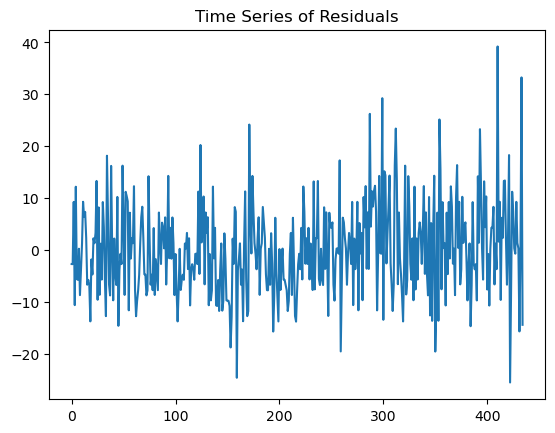

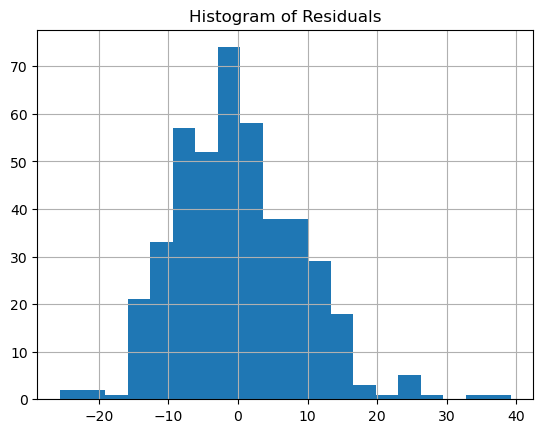

In [97]:
#ARIMA Residuals

mem_residuals = pd.DataFrame(arima_mem_fit.resid)

mem_residuals.plot(legend=False)
plt.title('Time Series of Residuals')

mem_residuals.hist(bins=20)
plt.title('Histogram of Residuals')


mem_residuals.head()

#Model Evaluation

The best-performing model of the three classification algorithms used (Ridge Regression, Support Vector Machines and Random Forest) is the Random Forest model. The precision and accuracy of the Random Forest model were .53 or 53% while the other classifiers had an accuracy of around 51%-52%. I also tried using ARIMA to categorize wins and losses for a specific team (Memphis Grizzlies) the best ARIMA model did not show the exact probability that the Grizzlies won their next game or not but it did show a trend of a losing season for 2023 which was true for them in that season. 

My recommendation is that the Random Forest model is the best of the three, but it is just a bit more accurate than a coin flip which isn't great.  Maybe applying some dimensionality reduction or using an ANN would be a better approach for this kind of data. As far as the time series ARIMA model is concerned; because ARIMA is not a categorical classifier, the model probably doesn't produce the output I am looking for. However it does show a pretty accurate trend. 
